In [1]:
import numpy as np
from numpy import pi, sin, cos
from scipy.optimize import least_squares
from scipy import odr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse, Circle
import matplotlib.patches as patches

In [2]:
# --- パラメータ ---------------------------------------------------------
A          = 1.0               # 半径
sigma_x    = 0.04              # x ノイズ SD
sigma_y    = 0.04              # y ノイズ SD
x_offset   = 0.05              # 真の中心 X
y_offset   = -0.04             # 真の中心 Y
phi_true   = 0.1              # 真の位相 (rad)
n_points   = 32                # 1 周あたりの点数
n_MC       = 2000               # モンテカルロ試行回数
rng        = np.random.default_rng(1234)

# --- データ生成 ---------------------------------------------------------
theta_grid = np.linspace(0, 2*pi, n_points, endpoint=False)

In [3]:
def generate_sample(
    A=A, x_offset=x_offset, y_offset=y_offset, phi_true=phi_true, n_points=n_points, rng=rng, sigma_x=sigma_x, sigma_y=sigma_y
    ):
    """1 試行分のノイズ付き (x, y) を返す"""
    A_noisy = A + rng.normal(0, 0.1)  # 半径のノイズ
    x_noisy = A_noisy * cos(theta_grid + phi_true) + x_offset + rng.normal(0, sigma_x, n_points)
    y_noisy = A_noisy * sin(theta_grid + phi_true) + y_offset + rng.normal(0, sigma_y, n_points)
    return x_noisy, y_noisy

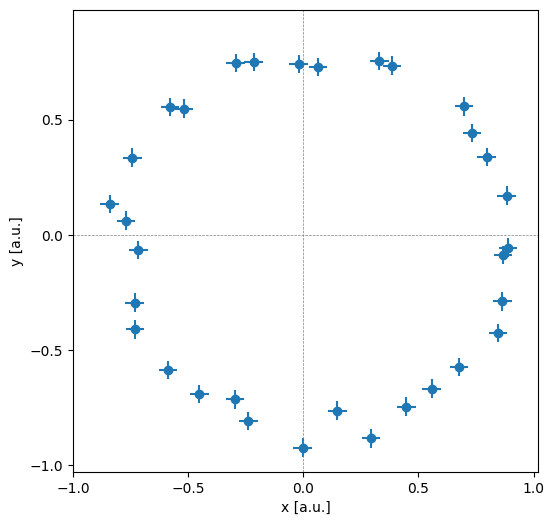

In [4]:
x_obs, y_obs = generate_sample()

fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
ax.errorbar(x_obs, y_obs, xerr=sigma_x, yerr=sigma_y, fmt='o', label='observed')
ax.axhline(0, color='gray', lw=0.5, ls='--')
ax.axvline(0, color='gray', lw=0.5, ls='--')

ax.axis('equal')
ax.set_xlabel('x [a.u.]')
ax.set_xticks(np.linspace(-1., 1., 5))
ax.set_ylabel('y [a.u.]')
ax.set_yticks(np.linspace(-1., 1., 5))

[Method 1](#method-1-cossin--offset)

[Method 2](#method-2-fit-the-circle-first-then-estimate-φ)

[Monte Carlo](#monte-carlo)

## Method 1: cos/sin + offset

In [5]:
def residuals_cos_sin(params, theta, x, y):
    phi, dx, dy, r = params
    return np.hstack([
        x - (r * np.cos(theta + phi) + dx),
        y - (r * np.sin(theta + phi) + dy)
    ])

def fit_cos_sin(theta, x, y):
    res = least_squares(residuals_cos_sin, x0=[-0.2, 0.0, 0.0, 1.],
                        args=(theta, x, y))
    phi_hat, dx_hat, dy_hat, r_hat = res.x
    # wrap φ in the range of -π–π
    phi_hat = (phi_hat + pi) % (2*pi) - pi
    # calibrate the standard error of φ
    dof = res.fun.size - res.x.size          # 2N - p
    s2  = res.cost * 2 / dof                 # res.cost = ½‖residual‖²
    JTJ_inv = np.linalg.inv(res.jac.T @ res.jac)
    phi_se  = np.sqrt(s2 * JTJ_inv[0, 0])

    return phi_hat, dx_hat, dy_hat, r_hat, phi_se

cx_hat = 0.054, cy_hat = -0.044, r_hat = 0.831
φ_hat = 0.093 ± 0.010 rad


(np.float64(-0.9706846803467054),
 np.float64(1.0183986084207828),
 np.float64(-1.0517183958413352),
 np.float64(0.8819098348462749))

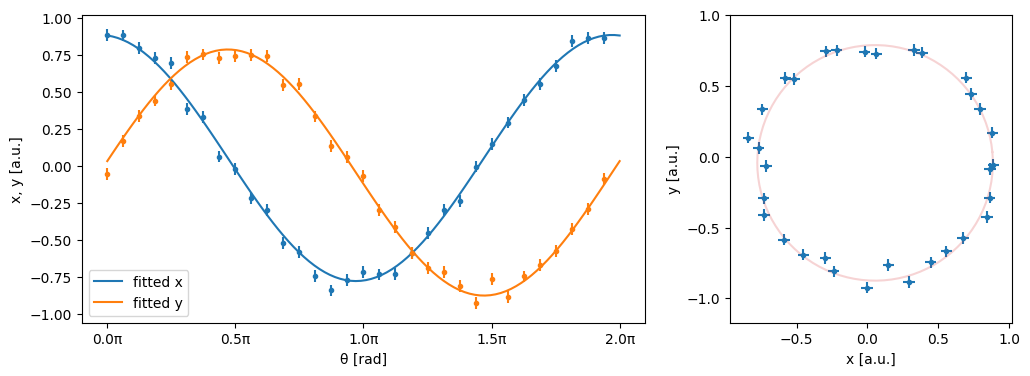

In [6]:
phi_hat, cx_hat, cy_hat, r_hat, phi_se = fit_cos_sin(theta_grid, x_obs, y_obs)
print(f'cx_hat = {cx_hat:.3f}, cy_hat = {cy_hat:.3f}, r_hat = {r_hat:.3f}')
print(f'φ_hat = {phi_hat:.3f} ± {phi_se:.3f} rad')

fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
_x = np.linspace(0., 2*pi, 100)
_y1 = r_hat * np.cos(_x + phi_hat) + cx_hat
_y2 = r_hat * np.sin(_x + phi_hat) + cy_hat
ax.errorbar(theta_grid, x_obs, yerr=sigma_x, fmt='.')
ax.errorbar(theta_grid, y_obs, yerr=sigma_y, fmt='.')
ax.plot(_x, _y1, label='fitted x', color='C0')
ax.plot(_x, _y2, label='fitted y', color='C1')
ax.set_xlabel('θ [rad]')
ax.set_xticks(np.linspace(0, 2*pi, 5), [f'{i/2:.1f}π' for i in range(5)])
ax.set_ylabel('x, y [a.u.]')
ax.legend(loc='lower left')

ax = fig.add_subplot(gs[0, 1])
ax.errorbar(x_obs, y_obs, xerr=sigma_x, yerr=sigma_y, fmt='.', label='observed')
ax.plot(_y1, _y2, label='fitted', color='C3', alpha=0.2)
ax.set_xlabel('x [a.u.]')
ax.set_xticks(np.linspace(-1., 1., 5))
ax.set_ylabel('y [a.u.]')
ax.set_yticks(np.linspace(-1., 1., 5))
ax.axis('equal')

## Method 2: Fit the circle first, then estimate φ

In [7]:
def fit_circle_odr(x, y, A_fixed=A, sx_val=sigma_x, sy_val=sigma_y):
    # ------------------------------
    # 1) Model （implicit=True）
    # ------------------------------
    def implicit_circle(beta, data):
        xc, yc, R = beta
        x_d, y_d = data           # data size is 2×N
        return (x_d - xc)**2 + (y_d - yc)**2 - R**2

    model = odr.Model(implicit_circle, implicit=True)

    # ------------------------------
    # 2) data ：x.shape=(2, N)
    #    declar model with y=1 (implicit model)
    # ------------------------------
    xy   = np.vstack([x, y])                       # shape=(2, N)
    sx   = np.vstack([sx_val*np.ones_like(x),      # shape=(2, N)
                         sy_val*np.ones_like(y)])
    data = odr.RealData(xy,                # x
                        y=1,               # <- y=1 for implicit model
                        sx=sx)             # x error

    # ------------------------------
    # 3) Initial parameters
    # ------------------------------
    beta0 = [x.mean(), y.mean(), A_fixed]

    odr_run = odr.ODR(data, model, beta0=beta0).run()
    return odr_run.beta # (xc, yc, R)

def estimate_phi_and_error(x, y, xc, yc):
    """中心補正後，φ̂ とその標準誤差を返す（円周統計を利用）"""
    angles = np.arctan2(y - xc*0 - yc, x - xc)  # == np.arctan2(y-yc, x-xc)
    diff   = angles - theta_grid
    # φ̂： argument of the mean of complex exponentials
    phi_hat = np.angle(np.mean(np.exp(1j * diff)))
    # sqrt(-2 ln R): standard deviation of the circular distribution
    R_bar   = np.abs(np.mean(np.exp(1j * (diff - phi_hat))))
    circ_sd = np.sqrt(-2 * np.log(R_bar))          # Fisher (1993)
    phi_se  = circ_sd / np.sqrt(len(diff))         # standard error

    # wrap [-π,π]
    phi_hat = (phi_hat + pi) % (2*pi) - pi
    return phi_hat, phi_se


xc_hat = 0.053, yc_hat = -0.033, A_hat = 0.833
φ_hat = 0.093 ± 0.010 rad


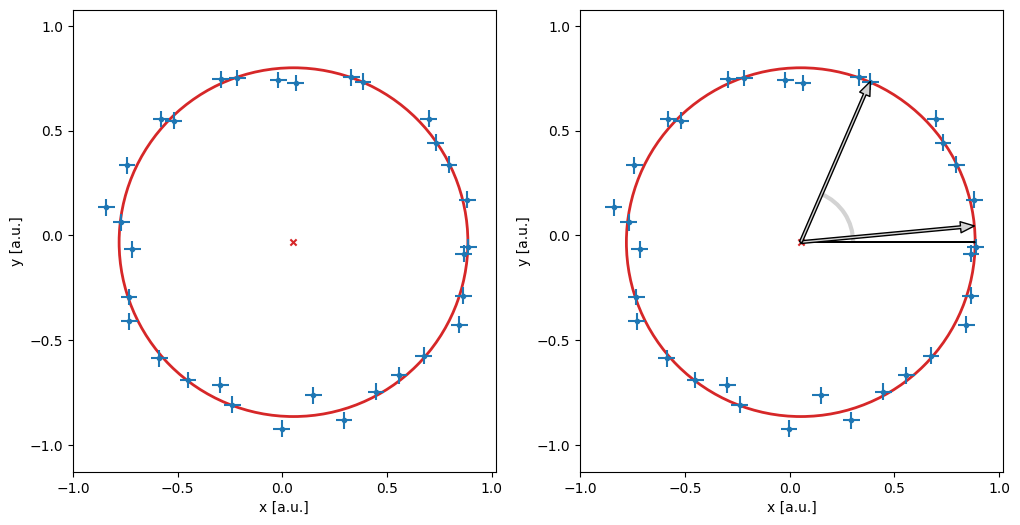

In [8]:
xc_hat, yc_hat, A_hat = fit_circle_odr(x_obs, y_obs, A_fixed=A)
print(f'xc_hat = {xc_hat:.3f}, yc_hat = {yc_hat:.3f}, A_hat = {A_hat:.3f}')

phi_hat, phi_se = estimate_phi_and_error(x_obs, y_obs, xc_hat, yc_hat)
print(f'φ_hat = {phi_hat:.3f} ± {phi_se:.3f} rad')

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1])

ax = fig.add_subplot(gs[0, 0])
ax.errorbar(x_obs, y_obs, xerr=sigma_x, yerr=sigma_y, fmt='.', label='observed')
circle = Circle(xy=(xc_hat, yc_hat), radius=A_hat, color='C3', fill=False, lw=2, label='fitted circle')
ax.add_artist(circle)
ax.scatter(xc_hat, yc_hat, color='C3', marker='x', s=20, label='center')
ax.axis('equal')
ax.set_xlabel('x [a.u.]')
ax.set_xticks(np.linspace(-1., 1., 5))
ax.set_ylabel('y [a.u.]')
ax.set_yticks(np.linspace(-1., 1., 5))

ax = fig.add_subplot(gs[0, 1])
ax.errorbar(x_obs, y_obs, xerr=sigma_x, yerr=sigma_y, fmt='.', label='observed')
circle = Circle(xy=(xc_hat, yc_hat), radius=A_hat, color='C3', fill=False, lw=2, label='fitted circle')
ax.add_artist(circle)
ax.scatter(xc_hat, yc_hat, color='C3', marker='x', s=20, label='center')


ax.annotate('',
            xy=[xc_hat + A_hat, yc_hat],
            xytext=[xc_hat, yc_hat],
            arrowprops=dict(
                shrink=0, width=0.1,
                headwidth=1, headlength=1,
                connectionstyle='arc3',
                facecolor='lightgray')
)

ax.annotate('',
            xy=[xc_hat + A_hat * cos(phi_hat), yc_hat + A_hat * sin(phi_hat)],
            xytext=[xc_hat, yc_hat],
            arrowprops=dict(
                shrink=0, width=2, headwidth=8,
                headlength=10, connectionstyle='arc3',
                facecolor='lightgray')
                )

ax.annotate('',
            xy=[x_obs[5], y_obs[5]],
            xytext=[xc_hat, yc_hat],
            arrowprops=dict(
                shrink=0, width=2, headwidth=8,
                headlength=10, connectionstyle='arc3',
                facecolor='lightgray')
                )


arc1 = patches.Arc(
        xy=(xc_hat, yc_hat),
        width=0.5, height=0.5,
        theta1=0,
        theta2=np.arctan2(y_obs[5] - yc_hat, x_obs[5] - xc_hat) * 180 / np.pi,
        angle=0,
        color='lightgray',
        lw=3,
        label='arc',
    )
ax.add_patch(arc1)

ax.axis('equal')
ax.set_xlabel('x [a.u.]')
ax.set_xticks(np.linspace(-1., 1., 5))
ax.set_ylabel('y [a.u.]')
ax.set_yticks(np.linspace(-1., 1., 5))

# Monte Carlo

In [9]:
# --- Monte Carlo  -------------------------------------------------------
phi_est1 = np.empty(n_MC)
phi_est2 = np.empty(n_MC)
phi_err1 = np.empty(n_MC)
phi_err2 = np.empty(n_MC)

for k in range(n_MC):
    x_obs, y_obs          = generate_sample()
    # ①
    phi_est1[k], _, _, _, phi_err1[k], = fit_cos_sin(theta_grid, x_obs, y_obs)
    # ②
    xc_hat, yc_hat, _               = fit_circle_odr(x_obs, y_obs, A_fixed=A)
    phi_est2[k], phi_err2[k]        = estimate_phi_and_error(x_obs, y_obs, xc_hat, yc_hat)

# summarize results
def summarize(arr):
    return np.mean(arr), np.std(arr, ddof=1)

mean1, std1 = summarize(phi_est1)
mean2, std2 = summarize(phi_est2)

print(f"Method ①:  bias={mean1 - phi_true:+.4e},  SD={std1:.4e}")
print(f"Method ②:  bias={mean2 - phi_true:+.4e},  SD={std2:.4e}")


Method ①:  bias=-1.5320e-04,  SD=7.3057e-03
Method ②:  bias=-1.4388e-04,  SD=7.3040e-03


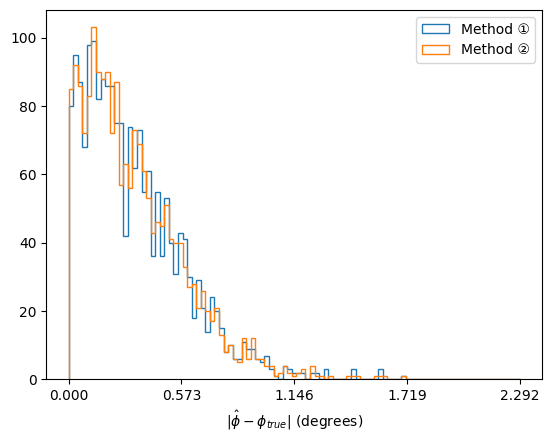

In [10]:
ax = plt.axes()
_bins = np.rad2deg(np.linspace(0., 0.04, 100))
_=ax.hist(np.rad2deg(np.abs(phi_est1 - phi_true)),histtype='step',bins=_bins,label='Method ①')
_=ax.hist(np.rad2deg(np.abs(phi_est2 - phi_true)),histtype='step',bins=_bins,label='Method ②')

ax.set_xticks(np.rad2deg(np.linspace(0., 0.04, 5)))
ax.set_xlabel(r"$|\hat{\phi} - \phi_{true}|$ (degrees)")
ax.legend(loc='upper right')

expected error = 0.573°


Text(0.5, 0, 'Estimated φ error (degrees)')

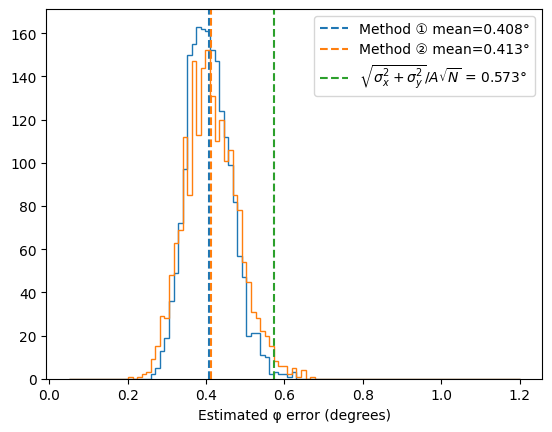

In [11]:
ax = plt.axes()
_bins = np.linspace(0.05,1.2,100)
_=ax.hist(np.rad2deg(phi_err1),histtype='step',bins=_bins)
_mean = np.mean(np.rad2deg(phi_err1))
ax.axvline(_mean, color='C0', linestyle='--', label=f'Method ① mean={_mean:.3f}°')

_=ax.hist(np.rad2deg(phi_err2),histtype='step',bins=_bins)
_mean = np.mean(np.rad2deg(phi_err2))
ax.axvline(_mean, color='C1', linestyle='--', label=f'Method ② mean={_mean:.3f}°')

expected_error = np.rad2deg((sigma_x**2 + sigma_y**2)**0.5 / A / np.sqrt(n_points))
print(f'expected error = {expected_error:.3f}°')
ax.axvline(expected_error, color='C2', linestyle='--', label=r'$\sqrt{\sigma_x^2 + \sigma_y^2} / A \sqrt{N}$ = ' +
           f'{expected_error:.3f}°')

ax.legend()
ax.set_xlabel('Estimated φ error (degrees)')
# ax.set_xscale('log')